# Lecture 5 - Data-Driven Analysis Using DynamicalSystems.jl

- Last week we saw how to model a dynamical system with a known dynamic rule using DynamicalSystems.jl. We also saw how to calculate various dynamical properties of such a system, for example, Lyapunov exponents.
<br>

- This week we will turn our attention to data-driven analysis using DynamicalSystems.jl. In other words, **we suppose that we observe some system without necessarily knowing the dynamic rule in advance**.
<br>

- More often than not, what we observe in real life isn't the entire phase, in which the dynamics unfold, but rather some projection of the state onto a lower dimensional space. That is why our discussion of data-driven algorithms will focus in particular on phase space reconstruction using coordinates embedding, as you saw in this part of the lecture.


## Contents

1. [Delay Coordinates Embedding](#embedding)
2. [Choosing the Optimal Delay Time](#time)
3. [Choosing the Optimal Embedding Dimension](#dimension)
4. [Putting It All Together](#together)
5. [Lyapunov Exponents](#lyapunov)
6. [Forecasts with Time Delay Embedding](#forecasts)
7. [Further Reading](#further-reading)

In [11]:
using Pkg
Pkg.activate(".")
Pkg.add(["DynamicalSystems", "NearestNeighbors", "CairoMakie"])

  Activating project at `~/Nextcloud/TUM-Dynamics-Lecture/lectures/lecture-5`
   Resolving package versions...
  No Changes to `~/Nextcloud/TUM-Dynamics-Lecture/lectures/lecture-5/Project.toml`
  No Changes to `~/Nextcloud/TUM-Dynamics-Lecture/lectures/lecture-5/Manifest.toml`


In [12]:
using DynamicalSystems, NearestNeighbors, CairoMakie

## 1. Delay Coordinates Embedding <a class="anchor" id="embedding"></a>

- Recall from the first part of the lecture that a scalar timeseries $s(t)$ can be embedded in a space of dimension $m$ via a time-delay embedding of the form $(s(t), s(t - \tau), s(t - 2\tau), \ldots, s(t - (m-1)\tau))$.
<br>

- To demonstrate delay coordinates embedding using DynamicalSystems.jl, we will "observe" the Lorenz system with a scalar measurement function $h : \mathbb{R}^3 \to \mathbb{R}$, such that our observation consists of a one-dimensional timeseries $s(t) = h(\mathbf{u}(t))$.
<br>

- For simplicity, we will take $s(t) = h(\mathbf{u}(t)) = x(t)$, that is, we observe only the $x$-coordinate. If the three dimensions of the Lorenz system correspond roughly to the rate of convection and the horizontal and vertical temperature variations, respectively, then this is like saying that we observe only the rate of convection.

In [3]:
h(u) = u[:, 1]  # Measurement function

h (generic function with 1 method)

In [6]:
# Generate synthetic data
ds = Systems.lorenz()
T = 100.0
Δt = 0.01
u = trajectory(ds, T; Ttr = 100.0, Δt)[1]

3-dimensional StateSpaceSet{Float64} with 10001 points
 -10.1378   -17.2152   17.3671
 -10.8539   -18.0832   18.7395
 -11.58     -18.8508   20.2925
 -12.3035   -19.477    22.0193
 -13.0091   -19.9182   23.9032
 -13.6789   -20.1303   25.9149
 -14.2923   -20.0738   28.0119
 -14.8277   -19.7169   30.1384
 -15.2629   -19.042    32.228
 -15.5769   -18.0487   34.2073
 -15.7519   -16.7575   36.0024
 -15.7746   -15.2095   37.5457
 -15.6377   -13.4641   38.7833
   ⋮                   
  10.0063     8.61855  30.5015
   9.85799    8.2839   30.5272
   9.69227    7.95625  30.5071
   9.51167    7.64024  30.4431
   9.31891    7.33993  30.3378
   9.11682    7.05875  30.1942
   8.90824    6.79948  30.0157
   8.69599    6.56423  29.8061
   8.48277    6.35448  29.569
   8.27116    6.17116  29.3084
   8.06354    6.01468  29.028
   7.86208    5.88502  28.7314

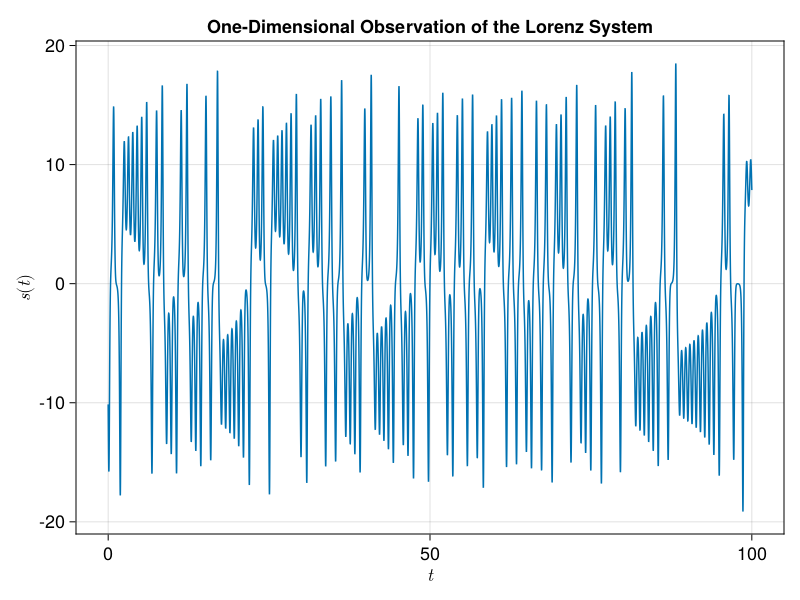

In [13]:
# "Measure" s(t) = h(u(t)) = x(t)
s = h(u)
fig = Figure(fontsize = 18)
ax = Axis(fig[1, 1], xlabel = L"t", ylabel = L"s(t)", title = "One-Dimensional Observation of the Lorenz System")
lines!(ax, 0:Δt:T, s)
fig

- To embed a one-dimensional timeseries $s(t)$ with embedding dimension $d$ and delay time $\tau \Delta t$, just do `embed(s, d, τ)` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/embed/#DelayEmbeddings.embed)).

In [14]:
d = 3
τ = 4
embed(s, d, τ)

3-dimensional StateSpaceSet{Float64} with 9993 points
 -10.1378   -13.0091   -15.2629
 -10.8539   -13.6789   -15.5769
 -11.58     -14.2923   -15.7519
 -12.3035   -14.8277   -15.7746
 -13.0091   -15.2629   -15.6377
 -13.6789   -15.5769   -15.341
 -14.2923   -15.7519   -14.8916
 -14.8277   -15.7746   -14.3031
 -15.2629   -15.6377   -13.5947
 -15.5769   -15.341    -12.7893
 -15.7519   -14.8916   -11.9117
 -15.7746   -14.3031   -10.987
 -15.6377   -13.5947   -10.039
   ⋮                   
  10.3656    10.3839    10.0063
  10.4079    10.325      9.85799
  10.4253    10.2416     9.69227
  10.4174    10.1348     9.51167
  10.3839    10.0063     9.31891
  10.325      9.85799    9.11682
  10.2416     9.69227    8.90824
  10.1348     9.51167    8.69599
  10.0063     9.31891    8.48277
   9.85799    9.11682    8.27116
   9.69227    8.90824    8.06354
   9.51167    8.69599    7.86208

- Let's plot the embedded attractor for a range of different delays $\tau$ and a fixed embedding dimension of 3.

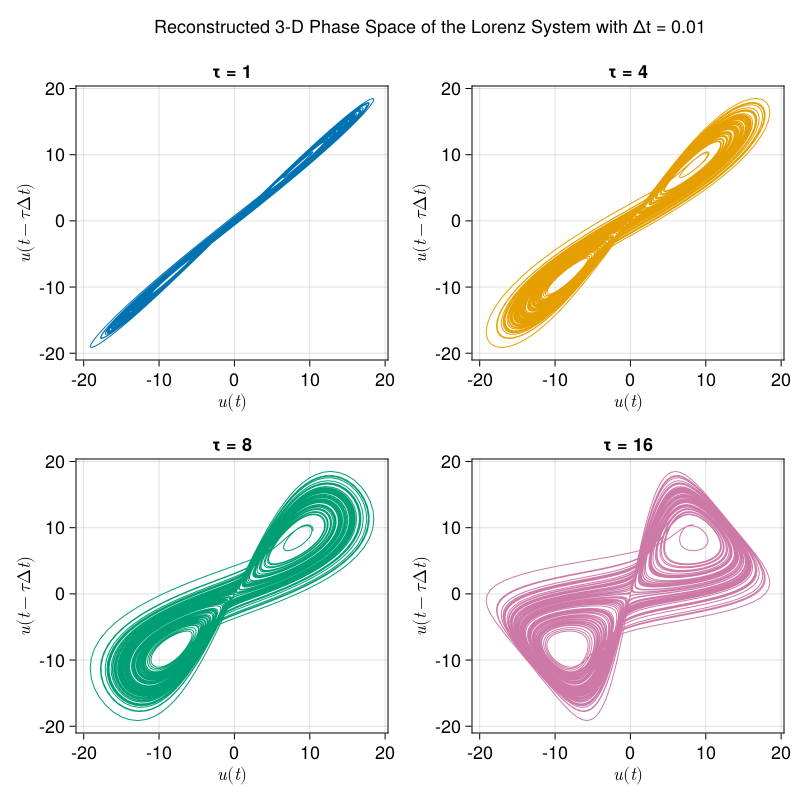

In [15]:
fig = Figure(resolution = (800, 800), fontsize = 18)
axes = [Axis(fig[1, 1]), Axis(fig[1, 2]), Axis(fig[2, 1]), Axis(fig[2, 2])]

for (i, τ) in enumerate([1, 4, 8, 16])
    data_embedded = embed(s, 3, τ)
    ax = axes[i]
    ax.title = "τ = $τ"
    ax.xlabel = L"u(t)"
    ax.ylabel = L"u(t-\tau \Delta t)"
    lines!(ax, data_embedded[:, 1], data_embedded[:, 2], color = Cycled(i), linewidth=1.0)
end

Label(fig[0, :], "Reconstructed 3-D Phase Space of the Lorenz System with Δt = $Δt")
fig

## 2. Choosing the Optimal Delay Time <a class="anchor" id="time"></a>

- Since no theorem exists guaranteeing an optimal choice of the delay time $\tau$, we must rely instead on a  **prescriptive approach**.
<br>

- As you saw in the first part of the lecture, two possibilities include using the **autocorrelation** and the **self mutual information** of the observed timeseries.
<br>

- Given the lack of an optimal method, it is especially important that we develop an intuitive understanding of the different approaches that are possible.
<br>

- Fortunately, while DynamicalSystems.jl provides useful high-level methods for estimating optimal time delays, it also exposes their low-level counterparts, permitting a more detailed and hands-on analysis.

### 2.1. Autocorrelation

- DynamicalSystems.jl uses the method `autocor` from the [StatsBase.jl](https://juliastats.org/StatsBase.jl/stable/) package for computing autocorrelations.
<br>

- It takes a one-dimensional timeseries as the first argument and an `AbstractVector` of lags as the second argument, returning a `Vector` of autocorrelations, one for each lag provided.

In [16]:
lags = 0:10
autocor(s, lags)

11-element Vector{Float64}:
 1.0
 0.9983760004718996
 0.9937715109203886
 0.9862465412201984
 0.9758992494285952
 0.9628631778046208
 0.9473035681277422
 0.9294129310451216
 0.9094060744771866
 0.8875148020451531
 0.863982496564643

- Let's plot the autocorrelation of our scalar Lorenz timeseries for various different lags.

In [17]:
function plot_autocor(s, lags)
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = L"\tau",
        xticks = 0:100:500,
        xminorticks = IntervalsBetween(2), 
        xminorticksvisible = true,
        xminorgridvisible = true,
        ylabel = "Autocorrelation", 
    )
    scatter!(ax, autocor(s, lags))
    return fig
end

plot_autocor (generic function with 1 method)

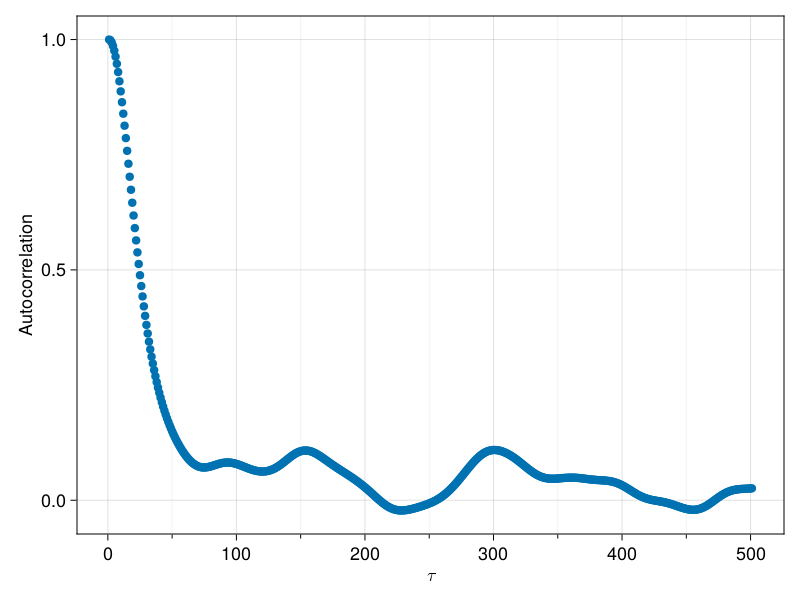

In [18]:
lags = 0:500
plot_autocor(s, lags)

- It looks like the first minimum occurs somewhere around $\tau = 100$, while the zero-crossing time is very long indeed, around $\tau = 275$.
<br>

- Sometimes, especially when embedding in higher dimensions, **relying on the crossing time of the autocorrelation can lead to very long delays**. 
<br>

- Another alternative is to choose as a delay the time taken for the autocorrelation function to decay to $1/e$ of its initial value. DynamicalSystems.jl provides the method `exponential_decay_fit(x, y)` which performs a least squares fit of the form $y = \exp(\frac{x}{\tau})$ and returns $\tau$.

In [19]:
x = 10:40  # You must choose the lags such that the autocorrelation remains positive
y = autocor(s, x)
exponential_decay_fit(x, y)

21.79155514165155

- Based on the autocorrelation, we already have three quite different estimates for the optimal delay, based on the first minimum, zero crossing time, and exponential decay.

### 2.2. Average Mutual Information

- As you learned earlier, a useful and often more robust alternative to autocorrelation is the average mutual information of the timeseries with itself at a given delay.
<br>

- DynamicalSystems.jl implements the method `selfmutualinfo(s, lags)` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.selfmutualinfo)).

In [20]:
lags = 0:10
selfmutualinfo(s, lags)

11-element Vector{Float64}:
 3.8986993314270033
 3.0832815768164665
 2.668922566356628
 2.386757061699135
 2.1733096043556905
 1.9925834060699958
 1.834036050342687
 1.7040078634261977
 1.5894861663052333
 1.4841139674186885
 1.3941995271992649

In [21]:
function plot_selfmutualinfo(s, lags)
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = L"\tau", 
        xminorticks = IntervalsBetween(5), 
        xminorticksvisible = true,
        xminorgridvisible = true,  
        ylabel = "Self Mutual Information", 
    )
    scatter!(ax, selfmutualinfo(s, lags))
    return fig
end

plot_selfmutualinfo (generic function with 1 method)

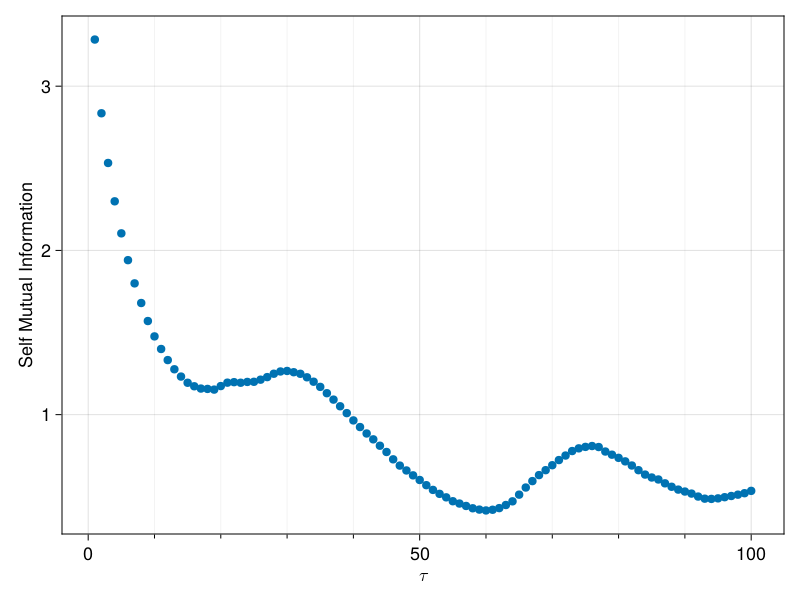

In [22]:
plot_selfmutualinfo(s, 1:100)

- It looks like the first minimum of the self mutual information occurs somewhere around $\tau = 17$, which is fairly similar to our previous estimate using exponential decay of the autocorrelation.

### 2.3. The `estimate_delay` Method

- DynamicalSystems.jl wraps all of these options in the convenient `estimate_delay` method ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.estimate_delay)).

In [23]:
estimate_delay(s, "ac_min")

74

In [25]:
estimate_delay(s, "ac_zero")

┌ Warning: Did not cross 0 value, returning last `τ`.
└ @ DelayEmbeddings ~/.julia/packages/DelayEmbeddings/YHZpu/src/separated_de/estimate_delay.jl:41


100

In [26]:
estimate_delay(s, "exp_decay")

29

In [27]:
estimate_delay(s, "mi_min")

19

- As you can see, there is quite a range of estimates for $\tau$, emphasising once again the importance of taking a heuristic approach,

## 3. Choosing the Optimal Embedding Dimension <a class="dimension" id="dimension"></a>

- Given an estimate for the time delay, we can proceed to find the embedding dimension using false nearest neighbours.
<br>

- In DynamicalSystems.jl, we can do this using the `delay_fnn` method ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.delay_fnn)).

In [28]:
function plot_fnn(s, delay, dims)
    fnn = delay_fnn(s, delay, dims)
    
    fig = Figure(fontsize = 18)
    ax = Axis(
        fig[1, 1], 
        xlabel = "Embedding Dimension",
        ylabel = "False Nearest Neighbours",
    )
    lines!(ax, dims, fnn)
    
    return fnn, fig
end

plot_fnn (generic function with 1 method)

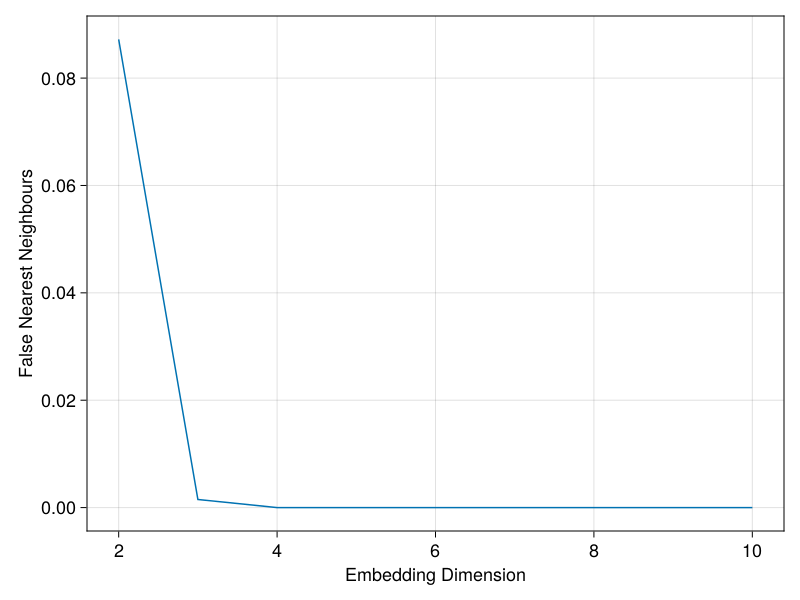

In [29]:
delay = 18
dims = 2:10
fnn, fig = plot_fnn(s, delay, dims)
fig

In [30]:
dims[findfirst(x -> x == 0, fnn)]

4

## 4. Putting It All Together <a class="anchor" id="together"></a>

- If you really do just want a quick embedding, you can fully automate the procedure outlined in the previous two sections using the method `optimal_separated_de` ([docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/separated/#DelayEmbeddings.optimal_separated_de)), which returns the embedded timeseries $D$, the delay used $\tau$, and the statistic $E$ used to calculate the optimal embedding dimension.

In [31]:
D, τ, E = optimal_separated_de(s)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional StateSpaceSet{Float64} with 9963 points, 19, [4.7675622309378216e-5, 0.20327846097225266, 0.880927955030191, 0.9288000573873432, 0.9530005139952228, 0.9705813569282291, 0.979118173886718, 0.9860861123961404, 0.9823709106846413, 1.0039709565829125])

- Here, "traditional" means that the algorithm first estimates $\tau$, and then, with $\tau$ fixed, finds the optimal embedding dimension.
<br>

- DynamicalSystems.jl also contains modern "unified" algorithms, which are more sophisticated and jointly optimise the delay and the embedding dimension. See the [docs](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/delayembeddings/stable/unified/) for more details.
<br>

- Given the computational resources we have at our disposal, yet another option is to optimise the embedding with respect to the specific task at hand. For example, if we wish to make timeseries predictions, we could choose the embedding which leads to the most accurate predictions on some validation dataset. 

## 5. Lyapunov Exponents <a class="anchor" id="lyapunov"></a>

- As you know by now, the maximum Lyapunov exponent of a chaotic system measures the exponential divergence of initially infinitesimally close trajectories,

$$|\delta (t)| \approx e^{\lambda t}|\delta (0)|.$$


- Taking the log of both sides and letting $E(t) = \ln|\delta (t)|$,

$$E(t) \approx \lambda \times t + E(0).$$


- Now assume that the timeseries is sampled at equal intervals $\Delta t$ and therefore discretise time by letting $t = k \times Δt$, where $k = 0, 1, 2, \ldots$, such that

$$E(k) \approx \lambda \times k \times Δt + E(0).$$


- Given some dataset, we can now estimate the maximum Lyapunov exponent as the slope of the plot of $E(k)$ versus $k \times Δt$.
<br>

- We can estimate $E(k)$ from the data as follows:

    1. Define neighbourhoods within the data consisting of trajectories which are initially close together (e.g. using nearest neighbours).  

    2. Given those neighbourhoods, step the system forward $k$ steps and take the average of $E(k) = \ln|\delta (k)|$ over all neighbourhoods.  <br><br>
    

- DynamicalSystems.jl makes this easy by providing the methods `lyapunov_from_data` and `linear_region`.

In [32]:
# Generate a longer timeseries than we used before
tr = trajectory(ds, 1000.0; Ttr = 100.0, Δt)[1]
# s = sin.(tr[:, 1])  # Try this for a more challenging observation
s = h(tr);

In [33]:
# Estimate the optimal embedding
D, τ, E = optimal_separated_de(s)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional StateSpaceSet{Float64} with 99967 points, 17, [4.680980278997141e-5, 0.1009413623769091, 0.9016721932228791, 0.9349299955105363, 0.9565350142738375, 0.9636974889211156, 0.9839685028200422, 0.9877436732854837, 0.9898524858949108, 0.9895393122762344])

┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/O7LoE/src/linear_fits/linear_regions.jl:142
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/O7LoE/src/linear_fits/linear_regions.jl:142
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/FractalDimensions/O7LoE/src/linear_fits/linear_regions.jl:142
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ FractalDimensions ~/.julia/packages/Fracta

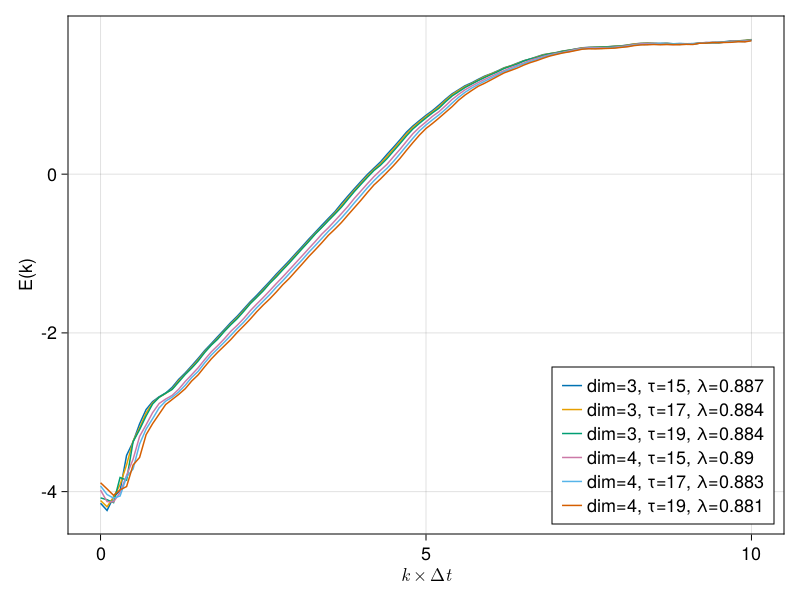

In [34]:
k_values = 0:10:1000  # Integer timesteps k * Δt

fig = Figure(figsize = (500, 500), fontsize = 18)
ax = Axis(fig[1, 1], xlabel = L"k \times Δt", ylabel="E(k)")

for dim in [3, 4], τ in [15, 17, 19]  # Try different embedding dimensions and time delays
    data_embedded = embed(s, dim, τ)
    E = lyapunov_from_data(data_embedded, k_values)  # Returns [E(k) for k ∈ k_values]
    λ = linear_region(k_values .* Δt, E)[2]          # Returns the slope of the linear region, i.e. the Lyapunov exponent
    lines!(
        ax, 
        k_values .* Δt, 
        E, 
        label = "dim=$(dim), τ=$(τ), λ=$(round(λ, digits = 3))",
    )
end

axislegend(ax, position = :rb)
fig

- How do these estimates compare to the true Lyapunov exponent?

In [35]:
lyapunov(ds, 10000.0, Ttr = 100)

0.9050943045159813

- Our estimates for the Lyapunov exponent are not bad at all! In particular, the best estimate corresponds exactly to the optimal embedding returned by the `optimal_separated_de` algorithm.
<br>

- This is really quite impressive when we remember that we started with a one-dimensional observation of the system and relied on a fully automated identification of the optimal embedding.

## 6. Forecasts with Time Delay Embeddings <a class="anchor" id="forecasts"></a>

One application of time-delay embedding is to use the embedding for forecasts. Here, we demonstrate a very simple model based on time-delay embedding 


First we generate some training data for the process, we want to forecast. 

In this first example, we generate data from a Lorenz system and only take the first / x dimension as training data. 

In the exercise you will apply this to temperature data.

First, we generate the Lorenz data and plot it, we'll only save the first, the x dimension, and pretend to forget about the other two variables.

In [36]:
ds = Systems.lorenz();
tr = trajectory(ds, 1000, Ttr=10.);
data = tr[1][:,1]; # just save the x variable 

Then, we perform a time delay embedding.

In [38]:
D, τ, E = DelayEmbeddings.optimal_traditional_de(data)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(4-dimensional StateSpaceSet{Float64} with 9995 points, 2, [0.00039446007116966203, 0.14954864169092238, 0.8432710655368097, 0.9294055546317769, 0.9508761318028393, 0.9800222936192196, 0.9839865707874407, 0.9828815974423022, 0.9844789441436712, 0.9942465982625607])

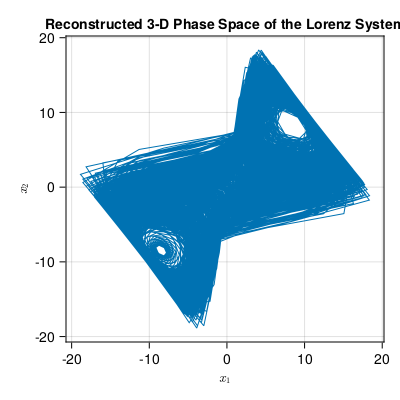

In [47]:
fig = Figure(resolution = (400, 400), fontsize = 14)
ax = Axis(fig[1, 1], xlabel = L"x_1", ylabel = L"x_2", title =  "Reconstructed 3-D Phase Space of the Lorenz System")

lines!(ax, D[:, 1], D[:, 2], color = Cycled(1), linewidth=1.0)
fig

# Time Series Prediction with Time Delay Embeddings 

We can use the time delay embedding to make forecasts of time series. 

The basic idea is the following: a point in the high-dimensional (fully embedded / unfolded) phase space will evolve similar to its neighbours in phase space. 

We can set up a simple version of a model using this idea as follows: 

* We find locally the $N_N$ neighbours of a point in phase space $\vec{v}^{(r)}(n)$, $r=1,2,..,N_N$
* Our ansatz is a local linear model that predicts the next point: $\vec{v}(r;n+1) = \mathbf{A}_n + \mathbf{B}_n\cdot\vec{v}^{(r)}(n)$
* The coefficients are determined by a least square fit at every point in the dataset that minimizes $$\sum_{r=0}^{N_N} \left|\vec{v}(r;n+1) - \mathbf{A}_n - \mathbf{B}_n\cdot\vec{v}^{(r)}(n)\right|^2$$
* We can do this minimization with a linear regression (`\` operator in Julia)
* If we then want to forecast one step ahead from a new point $\vec{z}(k)$, we look up its neareast neigbour $\vec{v}(NN)$ and predict its evolution with $$\vec{z}(k+1) = \mathbf{A}_{NN} + \mathbf{B}_NN\cdot \vec{z}(k)$$
* For longer predictions, we apply this procedure recursively

In [48]:
struct LocalTDEPrediction{T,S,U}
    A::T # regression coefficients 
    B::T # regression coefficients 
    N_N::S # amount of neighbours 
    tree::U # neighbourhood tree
end 

"""
    LocalTDEPrediction(data, N_N::Integer)

Sets up a local linear prediction model, based on a time delay embedding `data`. 
`data` is expected to be `N_t x N_dim`
The prediction is based on the dynamics a local model of `N_N` neighbours in phase
space
"""
function LocalTDEPrediction(data, N_N::Integer)
    neighbour_tree = KDTree(transpose(data[1:end-1,:])); # KDTree is expected it in N_dim x N_points format
    N_d = size(data, 2)
        
    A = zeros(size(data,1) -1, N_d)
    B = zeros(size(data,1) -1, N_d) 
    
    for i_point = 1:(size(data,1) -1)
        
        inds, dists = knn(neighbour_tree, D[i_point,:], N_N) # returns the N_N neighbours of i_point

        for i=:1:N_d 
            coeffs = hcat(ones(N_N), D[inds,i]) \ D[inds.+1,i] # linear regression, seperately for each dimension 
            # we could improve it with a proper MLR
    
            A[i_point, i] = coeffs[1]
            B[i_point, i] = coeffs[2]
        end
    end
    LocalTDEPrediction(A, B, N_N, neighbour_tree)
end 
     

LocalTDEPrediction

In [49]:
"""
    predict(pred::LocalTDEPrediction, ic::AbstractVector{T})

Predict the system one step ahead from state `ic`. 
"""
function predict(pred::LocalTDEPrediction, ic::AbstractVector{T}) where T
    inds, dists = knn(pred.tree, ic, 1) # first the closest point 
    ind = inds[1]
    
    return pred.A[ind,:] .+ pred.B[ind,:] .* ic
end 

"""
    predict(pred::LocalTDEPrediction, ic::AbstractVector{T}, N::Integer)

Recursively uses a one step ahead prediction to predict the system for `N` steps. 
"""
function predict(pred::LocalTDEPrediction, ic::AbstractVector{T}, N::Integer) where T
    
    result = zeros(T, length(ic), N+1)
    result[:,1] = ic
    
    for i=2:N+1 
        result[:,i] = predict(pred, result[:,i-1])
    end 
    
    return result
end 

predict

We split the data into a training and validation set and setup the prediction model

In [50]:
D = Matrix(D) # we have to convert D to a regular array before 

N_train = Int(floor(0.8*size(D,1)))

D_train = D[1:N_train,:]
D_valid = D[N_train+1:end,:]

pred = LocalTDEPrediction(D_train, 10)

LocalTDEPrediction{Matrix{Float64}, Int64, KDTree{SVector{4, Float64}, Euclidean, Float64}}([-10.273827231963908 -2.0012967390061154 0.7177939624913783 -8.853249007682773; 2.427364601436296 -7.4542906862326905 -1.7810674948087066 -2.4622865957753075; … ; -4.783548418415669 3.28659498170485 3.784915907688142 5.774007968889338; 2.316484370029259 2.5540750290346335 8.6439362735292 6.3752837872805825], [-0.11433158301447358 0.6833249799852402 1.1430758861784456 0.05059636648148353; 1.2111418317372609 0.026339844230381236 0.8760110010835452 0.6960574656187926; … ; 1.2299045382647649 0.5209265667636777 0.8280894230284841 0.20573894270606968; 0.49664833655260815 0.9020589347321442 0.18380805635850414 -0.045384861407256664], 10, KDTree{SVector{4, Float64}, Euclidean, Float64}
  Number of points: 7995
  Dimensions: 4
  Metric: Euclidean(0.0)
  Reordered: true)

Then, we apply the prediction.

In [51]:
N_predict = 200
prediction_result = predict(pred, D_valid[1,:], N_predict);
truth = D_valid[1:N_predict+1,:];

We try to predict the first dimension, as this is also our observable:

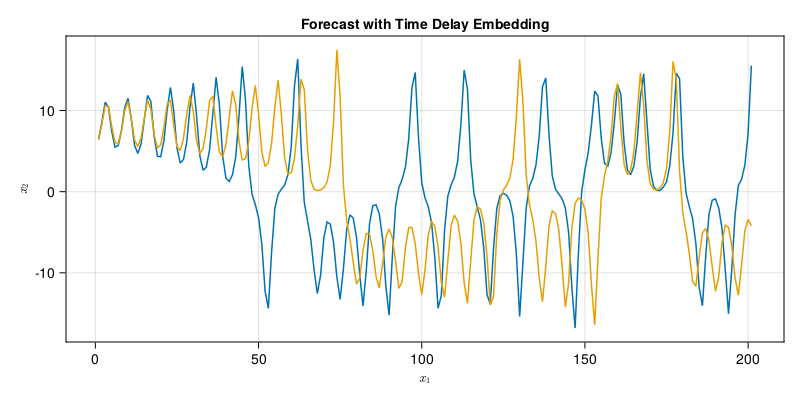

In [58]:
fig = Figure(resolution = (800, 400), fontsize = 14)
ax = Axis(fig[1, 1], xlabel = L"x_1", ylabel = L"x_2", title =  "Forecast with Time Delay Embedding")

lines!(ax, prediction_result[1,:], label="x - prediction")
lines!(ax, truth[:,1], label="Observable")

fig 

We could improve this method with more sophisticated local models than just the linear regression. But already like this, we get decent results for the Lorenz system. Remember, due to the chaotic nature of the Lorenz system even the smalles deviations will grow exponentially, so that forecast lengths will always be limited 

## 6. Further Reading <a class="anchor" id="further-reading"></a>

1. [DynamicalSystems.jl documentation](https://juliadynamics.github.io/DynamicalSystems.jl/dev/)
2. [DelayEmbeddings.jl documentation](https://juliadynamics.github.io/DelayEmbeddings.jl/dev/)
3. [Nonlinear Time Series Analysis (Kantz & Schreiber 2003)](https://www.cambridge.org/core/books/nonlinear-time-series-analysis/519783E4E8A2C3DCD4641E42765309C7)
4. [Analysis of Observed Chaotic Data (Abarbanel 1996)](https://link.springer.com/book/10.1007/978-1-4612-0763-4)